In [1]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import dfols
import signal
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy import interpolate
from stopit import threading_timeoutable as timeoutable
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from stopit import threading_timeoutable as timeoutable
from batfuns import *
plt.rcParams = set_rc_params(plt.rcParams)

eSOH_DIR = "../data/esoh_R/"
oCV_DIR = "../data/ocv/"
fig_DIR = "../figures/figures_fit/"
res_DIR = "../data/results_fit/"
cyc_DIR = "../data/cycling/"
# %matplotlib widget

In [2]:
parameter_values = get_parameter_values()

In [3]:
# parameter_values.search("Li")

In [4]:
spm = pybamm.lithium_ion.SPM(
    {
        "SEI": "ec reaction limited",
        # "loss of active material": ("stress-driven","none"),
        "loss of active material": "stress-driven",
        "lithium plating": "irreversible",
        "stress-induced diffusion": "false",
    }
)
# spm.print_parameter_info()
param=spm.param

In [5]:
cell = 7

## Load eSOH Data and OCV Data

In [6]:
cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
eps_n_data,eps_p_data,c_rate_c,c_rate_d,dis_set,Temp,SOC_0 = init_exp(cell_no,dfe,spm,parameter_values)

In [7]:
pybamm.set_logging_level("WARNING")
# pybamm.set_logging_level("NOTICE")
drive_cycle = pd.read_csv(cyc_DIR+'peyman_drive_cycle_current'+'.csv', comment="#", header=None).to_numpy()
experiment = pybamm.Experiment(
    [
        ("Discharge at "+c_rate_d+dis_set,
         "Rest for 5 min",
         "Charge at "+c_rate_c+" until 4.2V", 
         "Hold at 4.2V until C/100")
    ] *dfe.N.iloc[-1],
    termination="50% capacity",
#     cccv_handling="ode",
)

In [8]:
ic = 2
blam_p = [8.5870e-08,2e-08,5e-9]
blam_n = [2.8829e-07,1e-07,5e-8]
blam_p2 = [7.6933e-11,2e-09,1e-10]
blam_n2 = [7.6933e-11,1e-08,1e-9]
k_pl = [2.8285e-09,2e-09,2e-09]
x0 = np.array([1.0,1.0,1.1/2,1.0,-1,-1])

In [9]:
parameter_values = get_parameter_values()
parameter_values.update(
    {
        "Negative electrode active material volume fraction": eps_n_data,
        "Positive electrode active material volume fraction": eps_p_data,
        "Initial temperature [K]": 273.15+Temp,
        "Ambient temperature [K]": 273.15+Temp,
        # "Positive electrode LAM constant proportional term [s-1]": 1.27152e-07,
        # "Negative electrode LAM constant proportional term [s-1]": 1.27272e-06,
        # "Positive electrode LAM constant exponential term": 1.1992,
        # "Negative electrode LAM constant exponential term": 1.1992,
        "SEI kinetic rate constant [m.s-1]":  4.60788219e-16, #1.08494281e-16 , 
        "EC diffusivity [m2.s-1]": 4.56607447e-19,#8.30909086e-19,
        "SEI growth activation energy [J.mol-1]": 1.87422275e+04,#1.58777981e+04,
        # "Lithium plating kinetic rate constant [m.s-1]": 0,
        "Initial inner SEI thickness [m]": 0e-09,
        "Initial outer SEI thickness [m]": 5e-09,
        "SEI resistivity [Ohm.m]": 30000.0,
        "Positive electrode LAM constant proportional term [s-1]": x0[0]*blam_p[ic],
        "Negative electrode LAM constant proportional term [s-1]": x0[1]*blam_n[ic],
        "Positive electrode LAM constant exponential term": x0[2]*2,
        "Negative electrode LAM constant exponential term": x0[2]*2,
        "Lithium plating kinetic rate constant [m.s-1]": x0[3]*k_pl[ic],
        "Positive electrode LAM constant proportional term 2 [s-1]": x0[5]*blam_p2[ic],
        "Negative electrode LAM constant proportional term 2 [s-1]": x0[4]*blam_n2[ic],
        "Negative electrode partial molar volume [m3.mol-1]": 7e-06,
        "Negative electrode LAM min stress [Pa]": 0,
        "Negative electrode LAM max stress [Pa]": 0,
        "Positive electrode LAM min stress [Pa]": 0,
        "Positive electrode LAM max stress [Pa]": 0,
        # "Negative electrode critical stress [Pa]": 20e+06,
        # "Positive electrode critical stress [Pa]": 40e+06,
    },
    check_already_exists=False,
)


In [10]:
all_sumvars_dict = cycle_adaptive_simulation_V2(spm, parameter_values, experiment,SOC_0, save_at_cycles=1)

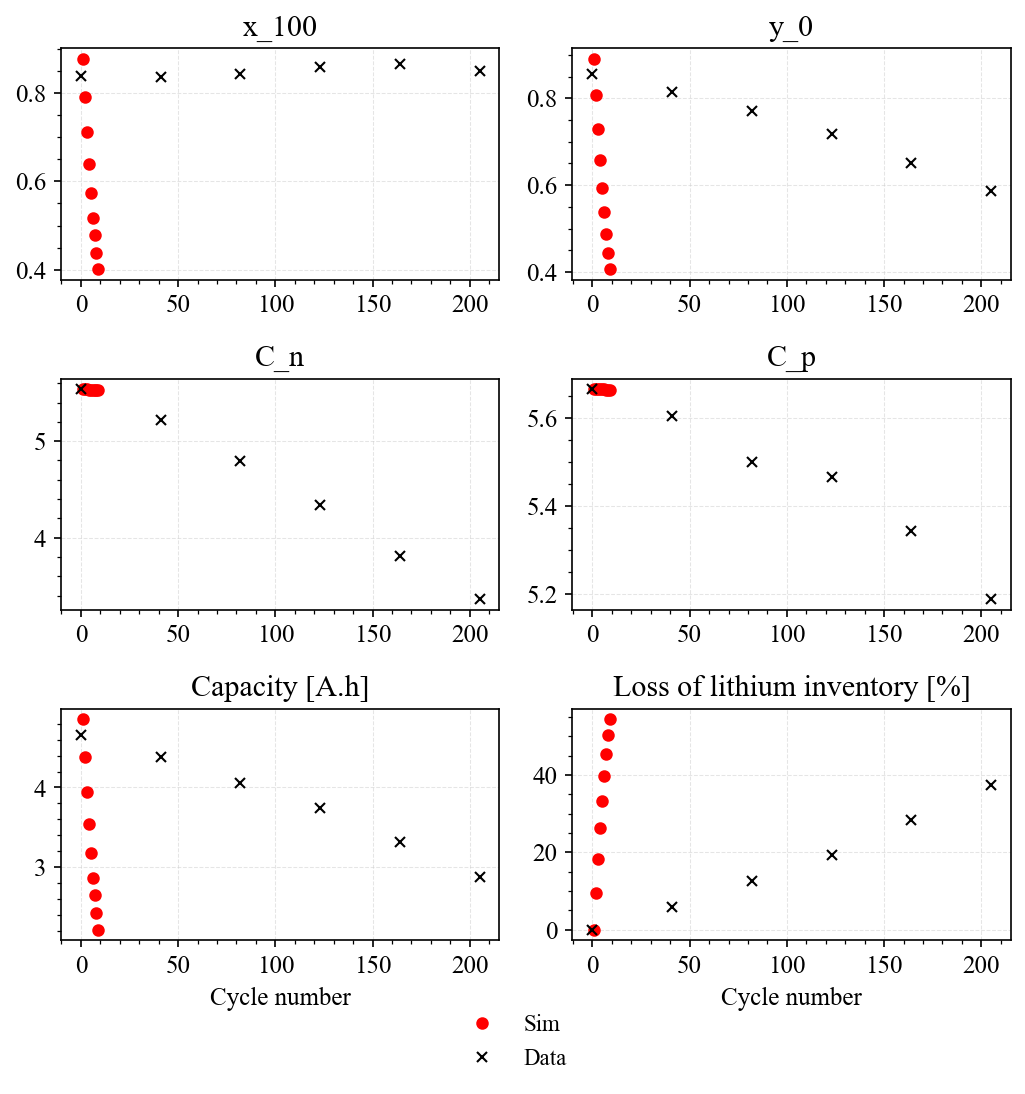

In [11]:
fig = plotc(all_sumvars_dict,dfe);
# fig.savefig(fig_DIR +'fast_sim_'+cell_no+'_new.png')

In [12]:
# fgdfdfg

# Parameter Fitting

## List of Initial Conditions

In [13]:
ic = 3
blam_p = [8.5870e-08,2e-08,5e-9,4.0312e-08]
blam_n = [2.8829e-07,1e-07,5e-8,1.8157e-07]
blam_p2 = [7.6933e-11,2e-09,1e-10,1.4406e-09]
blam_n2 = [7.6933e-11,1e-09,1e-9,4.9170e-09]
k_pl = [2.8285e-09,2e-09,2e-09,4e-3*2.3586e-09] #4e-3
#,1.0776,4.02453059e-03*,-4.9170e-09,-1.4406e-09
# 8.5870e-09,2.8829e-07,1.0451,2.8285e-09,7.6933e-11
 # variables = ["Capacity [A.h]", "Loss of lithium inventory [%]","x_100","y_0"]
    # weights = [1,1/20,5,5]

In [14]:
def objective(model, data):
    return np.array(model.loc[data['N_mod']]["Capacity [A.h]"]) - np.array(data["Capacity [A.h]"])

def multi_objective(model, data):
    variables = ["C_n","C_p","x_100","y_0"]
    weights = [1,1,5,5]
    # variables = ["Capacity [A.h]", "Loss of lithium inventory [%]"]
    # # weights = [1,1/20]
    variables = ["Capacity [A.h]", "Loss of lithium inventory [%]", "C_n", "C_p"]
    weights = [1,1/20,1,1]
    return np.concatenate([
        (np.array(model.loc[data['N_mod']][var]) - np.array(data[var])) * w
        for w,var in zip(weights,variables)
    ]
    )
@timeoutable()
def simulate(x,eps_n_data,eps_p_data,SOC_0,Temp,experiment,parameter_values):
    # simulate
    return cycle_adaptive_simulation_V2(spm, parameter_values, experiment, SOC_0,save_at_cycles=1,drive_cycle=None)
def prediction_error(x):
    cells = [1,4,10]
    try:
        out=[]
        for cell in cells:
            cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
            eps_n_data,eps_p_data,c_rate_c,c_rate_d,dis_set,Temp,SOC_0 = init_exp(cell_no,dfe,spm,parameter_values)
            # print(f"Cell: {cell_no}")
            if cell == 19:
                experiment = pybamm.Experiment(
                    [
                        ("Run DriveCycle (A)",
                        "Rest for 5 min",
                        "Charge at "+c_rate_c+" until 4.2V", 
                        "Hold at 4.2V until C/50")
                    ] *dfe.N.iloc[-1],
                    # ] *1,
                    drive_cycles={"DriveCycle": drive_cycle},
                    termination="50% capacity",
                #     cccv_handling="ode",
                )
            else:
                experiment = pybamm.Experiment(
                    [
                        ("Discharge at "+c_rate_d+dis_set,
                        "Rest for 5 min",
                        "Charge at "+c_rate_c+" until 4.2V", 
                        "Hold at 4.2V until C/50")
                    ] *dfe.N.iloc[-1],
                    termination="50% capacity",
                #     cccv_handling="ode",
                )
            parameter_values.update(
                {
                    "Positive electrode LAM constant proportional term [s-1]": x[0]*blam_p[ic],
                    "Negative electrode LAM constant proportional term [s-1]": x[1]*blam_n[ic],
                    "Positive electrode LAM constant exponential term": x[2]*2,
                    "Negative electrode LAM constant exponential term": x[2]*2,
                    "Lithium plating kinetic rate constant [m.s-1]": x[3]*k_pl[ic],
                    "Positive electrode LAM constant proportional term 2 [s-1]": x[5]*blam_p2[ic],
                    "Negative electrode LAM constant proportional term 2 [s-1]": x[4]*blam_n2[ic],
                    "Negative electrode active material volume fraction": eps_n_data,
                    "Positive electrode active material volume fraction": eps_p_data,
                    "Initial temperature [K]": 273.15+Temp,
                    "Ambient temperature [K]": 273.15+Temp,
                    "Negative electrode LAM min stress [Pa]": 0,
                    "Negative electrode LAM max stress [Pa]": 0,
                    "Positive electrode LAM min stress [Pa]": 0,
                    "Positive electrode LAM max stress [Pa]": 0,
                },
                check_already_exists=False,
            )
            if cell == 10 or cell == 16:
               parameter_values.update(
                    {
                        "Negative electrode LAM constant proportional term 2 [s-1]": x[4]*blam_n2[ic],

                    },
                    check_already_exists=False,
                ) 
            # print(f"Model")
            model = cycle_adaptive_simulation_V2(spm, parameter_values, experiment, SOC_0,save_at_cycles=1,drive_cycle=None)
            # print(f"Objective")
            out_t =   1/len(dfe)*multi_objective(pd.DataFrame(model), dfe)
            # out_t = [np.linalg.norm(out_t)]
            # print(out_t)
            # out_t[-1] = 5*out_t[-1]
            # print(f"Concat")
            out=np.concatenate([out,out_t])
        print(f"x={x}, norm={np.linalg.norm(out)}")
    # except pybamm.SolverError:
    except:
        out=[]
        for cell in cells:
            cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
            # out_t = np.concatenate([np.array(dfe['Cap'])]*2)
            out_t = 1/len(dfe)*np.concatenate([np.array(dfe['Cap'])]*4)
            out=np.concatenate([out, out_t])
        out = 2*np.ones_like(out)
        print(f"Error")
        print(f"x={x}, norm={np.linalg.norm(out)}")
    return out

def train_model():
    timer = pybamm.Timer()
    x0 = np.array([1.0,1.0,1.1/2,1.0,-1,-1])
    # print(prediction_error(x0))
    lower = np.array([1e-2, 1e-2, 0.51, 1e-1, -1e+2, -1e+2])
    upper = np.array([1e+2, 1e+2, 1.50, 1e+1, -1e-2, -1e-2])
    # upper = np.array([1e+2, 1e+2, 1.50, 1e+1, -1e-2, -1e-2])
    dfo_opts = {
        "init.random_initial_directions":True,
        "init.run_in_parallel": True,
    }
    soln_dfols = dfols.solve(prediction_error, x0,bounds=(lower, upper), rhoend=1e-2, user_params=dfo_opts)
    print(timer.time())
    return soln_dfols
def sim_train(df):
    soln_dfols = train_model()
    xsol = soln_dfols.x
    # print(xsol[0]*2e-2/3600)
    # print(xsol[1]*2e-1/3600)
    # print(xsol[2]*1.6e-16)
    df['x_0'][0]=round(xsol[0],4)*blam_p[ic]
    df['x_1'][0]=round(xsol[1],4)*blam_n[ic]
    df['x_2'][0]=round(xsol[2]*2,4)
    df['x_3'][0]=round(xsol[3],4)*k_pl[ic]
    # df['x_4'][0]=round(xsol[4],4)*alam_p[ic]
    df['x_4'][0]=round(xsol[4],4)*blam_n2[ic]
    df['x_5'][0]=round(xsol[5],4)*blam_p2[ic]
    df['obj'][0]=soln_dfols.f
    return xsol,df

In [15]:
df_x = pd.DataFrame(columns=['x_0','x_1','x_2','x_3','x_4','x_5','obj'], index=[0])

In [16]:
x,df_x = sim_train(df_x)

x=[ 1.    1.    0.55  1.   -1.   -1.  ], norm=0.14926738086302166
x=[ 0.95894511  0.99554937  0.51        1.00736415 -0.93688469 -0.99633236], norm=0.15406766127769114
x=[ 0.9975618   0.9587817   0.61370171  0.9546828  -0.96026205 -0.97541452], norm=0.22475455647024684
x=[ 1.05665126  0.96846312  0.51        0.98100158 -0.98868647 -0.99691823], norm=0.1520658547891941
x=[ 0.96541693  0.99131259  0.51809883  0.96378599 -1.04301953 -0.93255579], norm=0.1504451093862062
x=[ 0.96560926  0.96992661  0.53608749  0.95136934 -1.02360932 -1.06926015], norm=0.15000771493102832
x=[ 0.98477286  0.92439477  0.55414577  1.06019578 -1.01986842 -0.99593678], norm=0.1665727023938046
x=[ 1.02997068  0.9993657   0.53084291  1.09315379 -0.99337878 -0.99640932], norm=0.14205373803130042
x=[ 1.01191399  0.97855828  0.53332246  1.44506258 -0.8505438  -0.87396247], norm=0.13586862841971326
x=[ 1.06758136  0.99678231  0.56179396  1.55751929 -0.73505584 -0.01      ], norm=0.1479847072159529
x=[ 0.97444176  0.98

In [17]:
sim_des="plating_mech_1_4_10_V5"
df_x.to_csv(res_DIR + "cycl_train_"+sim_des+".csv")

In [18]:
7.5**2

56.25

In [19]:
xsol = x

In [20]:
print(f"{df_x['x_0'][0]:0.4e},{df_x['x_1'][0]:0.4e},{df_x['x_2'][0]},{df_x['x_3'][0]:0.4e},{df_x['x_4'][0]:0.4e},{df_x['x_5'][0]:0.4e}")

4.0260e-08,1.7690e-07,1.0613,1.4276e-11,-3.9503e-09,-1.7136e-09


In [21]:
def plotcn(all_sumvars_dict,esoh_data):
    esoh_vars = ["x_100", "y_0", "C_n_loss", "C_p_loss", "Capacity [A.h]", "Loss of lithium inventory [%]"]
    all_sumvars_dict["C_n_loss"] = (all_sumvars_dict["C_n"][0]-all_sumvars_dict["C_n"])/all_sumvars_dict["C_n"][0]*100
    all_sumvars_dict["C_p_loss"] = (all_sumvars_dict["C_p"][0]-all_sumvars_dict["C_p"])/all_sumvars_dict["C_p"][0]*100
    esoh_data["C_n_loss"] = (esoh_data["C_n"][0]-esoh_data["C_n"])/esoh_data["C_n"][0]*100
    esoh_data["C_p_loss"] = (esoh_data["C_p"][0]-esoh_data["C_p"])/esoh_data["C_p"][0]*100
    fig, axes = plt.subplots(3,2,figsize=(7,7))
    for k, name in enumerate(esoh_vars):
        ax = axes.flat[k]
        ax.plot(all_sumvars_dict["Cycle number"],all_sumvars_dict[name],"ro")
        ax.plot(esoh_data["N"],esoh_data[name],"kx")
        ax.set_title(split_long_string(name))
        # if k ==2 or k==3:
        #     ax.set_ylim([3,6.2])
        if k>3:
            ax.set_xlabel("Cycle number")
    fig.legend(["Sim"] + ["Data"], 
           loc="lower center",bbox_to_anchor=[0.5,-0.02], ncol=1, fontsize=11)
    fig.tight_layout()
    return fig

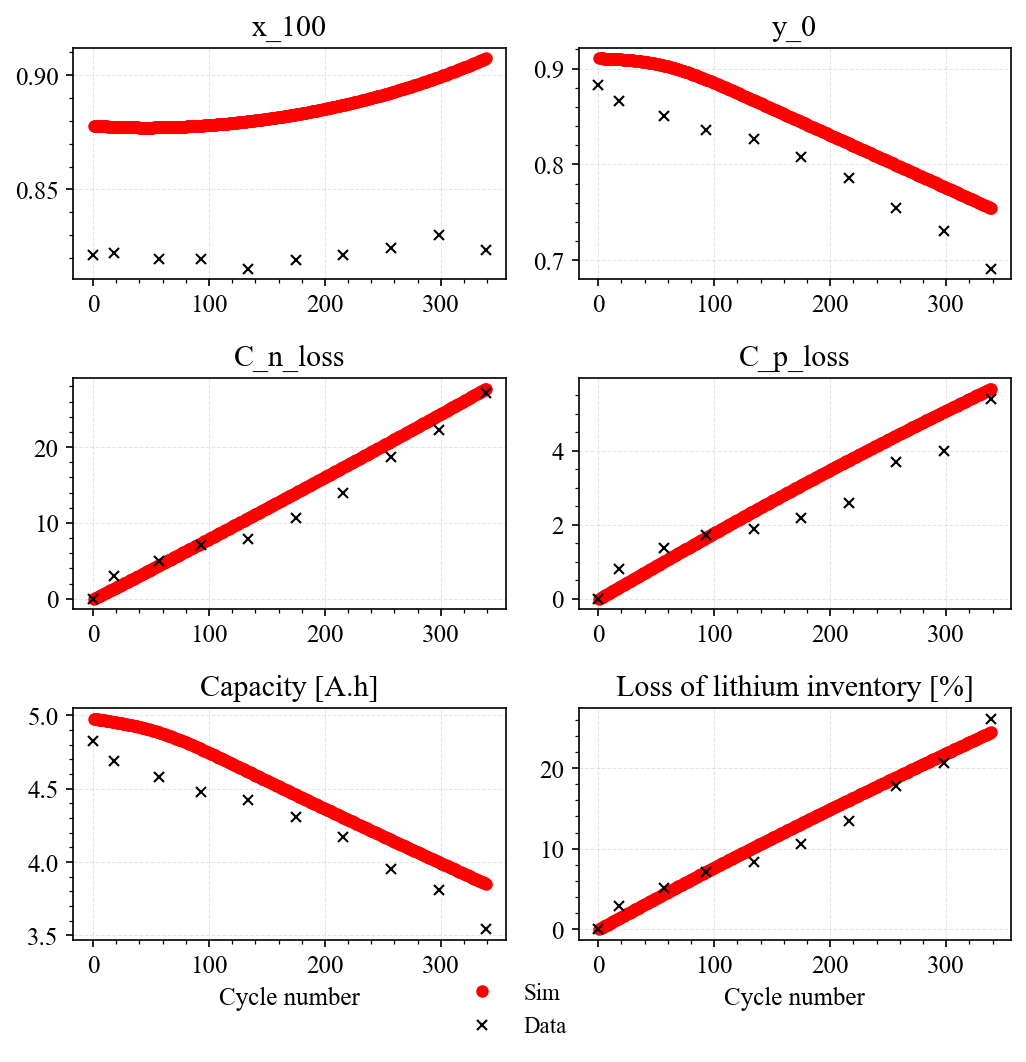

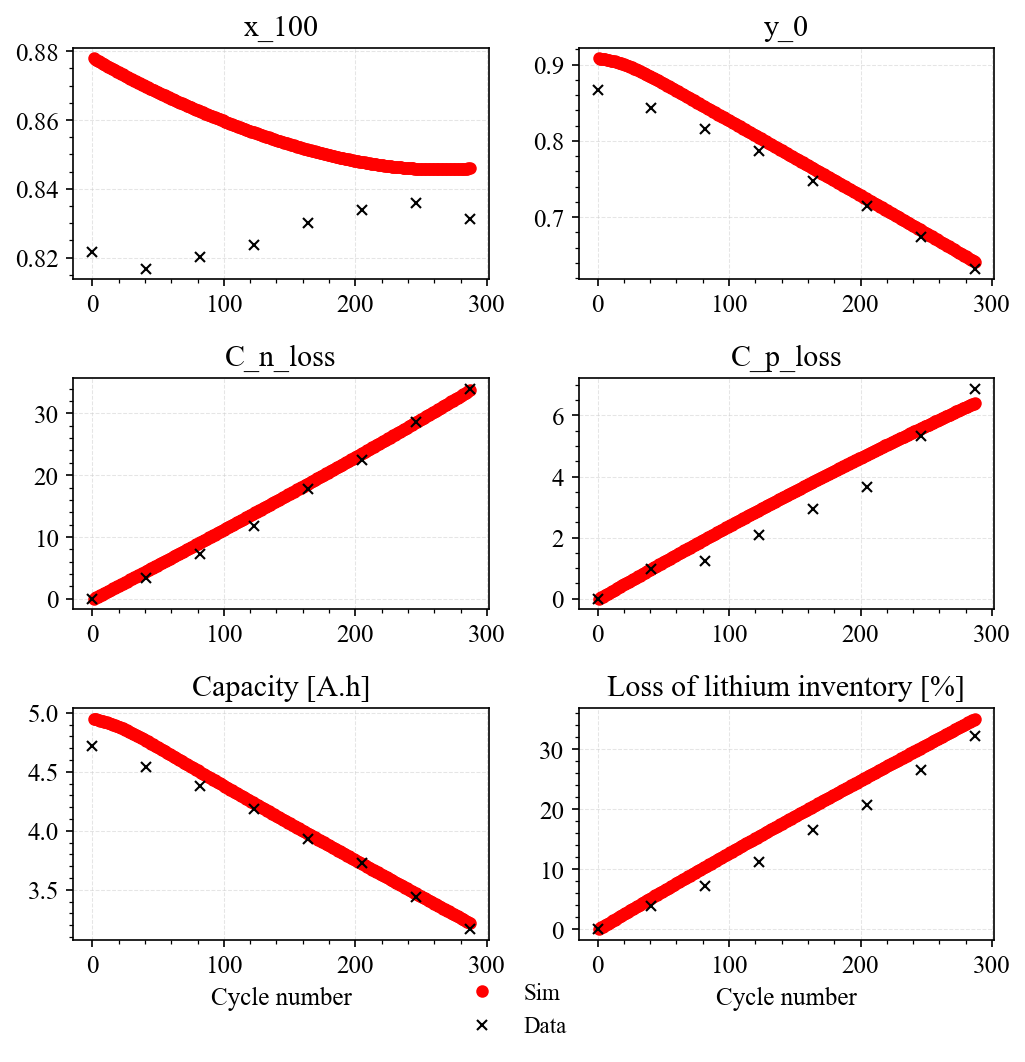

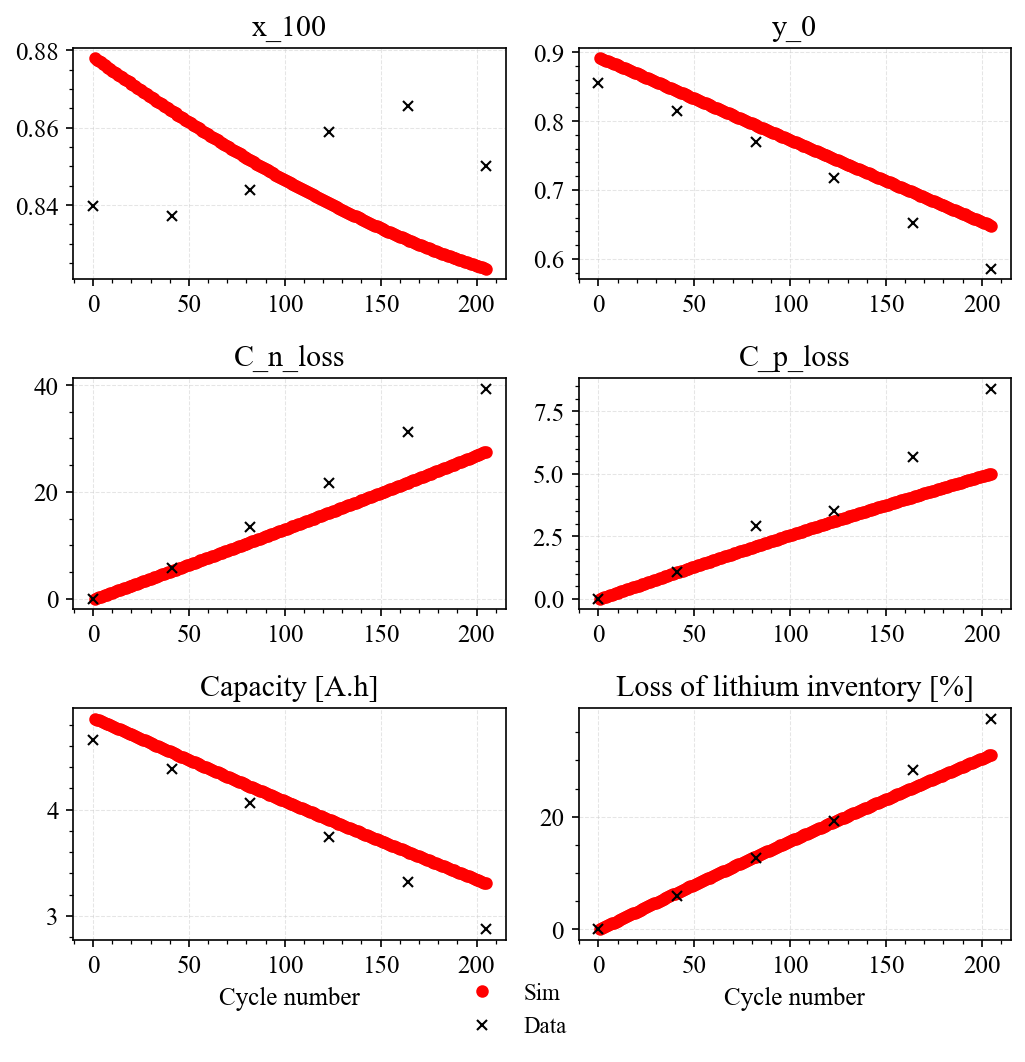

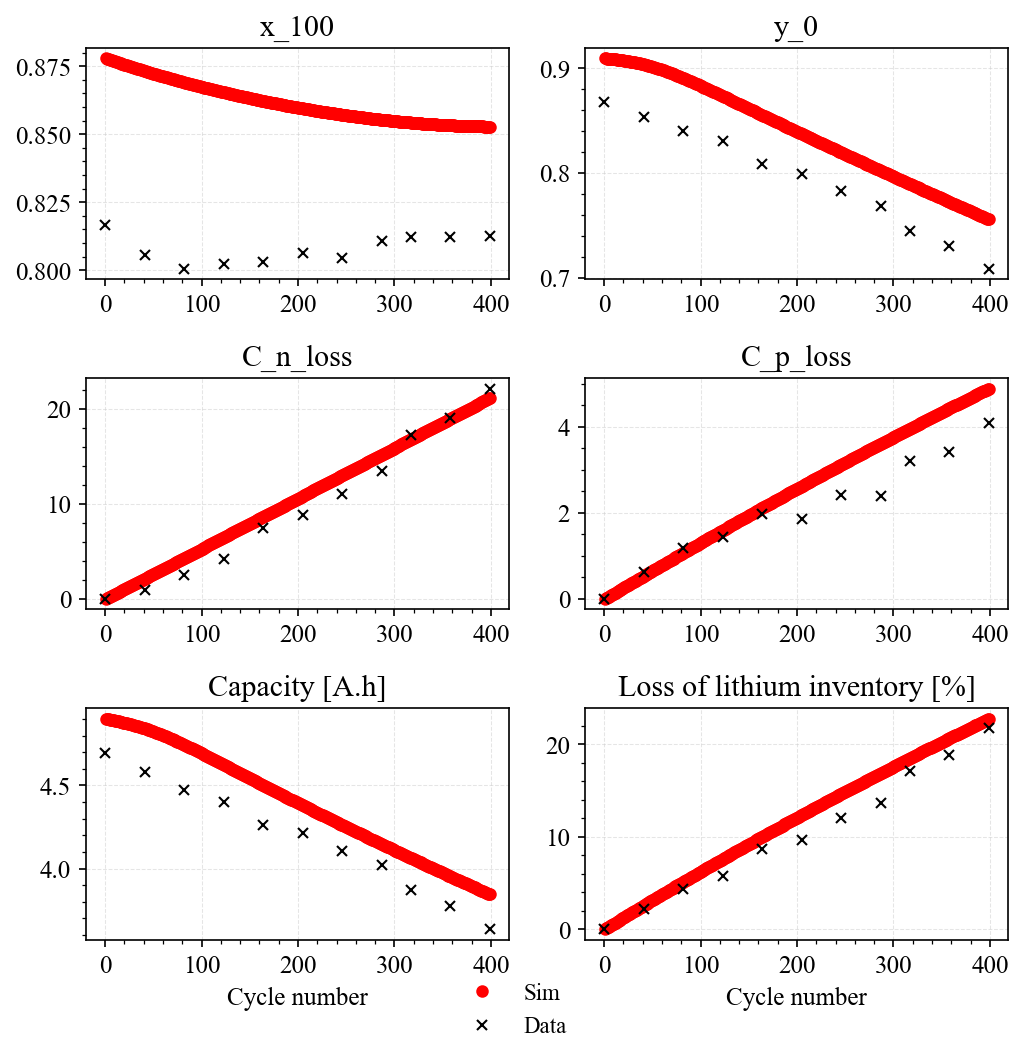

In [22]:
for cell in [1,4,7,10]:
    cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
    eps_n_data,eps_p_data,c_rate_c,c_rate_d,dis_set,Temp,SOC_0 = init_exp(cell_no,dfe,spm,parameter_values)
    # print(f"Cell: {cell_no}")
    experiment = pybamm.Experiment(
        [
            ("Discharge at "+c_rate_d+dis_set,
            "Rest for 5 min",
            "Charge at "+c_rate_c+" until 4.2V", 
            "Hold at 4.2V until C/100")
        ] *dfe.N.iloc[-1],
        termination="50% capacity",
    #     cccv_handling="ode",
    )
    parameter_values.update(
        {
            "Positive electrode LAM constant proportional term [s-1]": x[0]*blam_p[ic],
            "Negative electrode LAM constant proportional term [s-1]": x[1]*blam_n[ic],
            "Positive electrode LAM constant exponential term": x[2]*2,
            "Negative electrode LAM constant exponential term": x[2]*2,
            "Lithium plating kinetic rate constant [m.s-1]": x[3]*k_pl[ic],
            "Positive electrode LAM constant proportional term 2 [s-1]": x[5]*blam_p2[ic],
            "Negative electrode LAM constant proportional term 2 [s-1]": x[4]*blam_n2[ic],
            "Negative electrode active material volume fraction": eps_n_data,
            "Positive electrode active material volume fraction": eps_p_data,
            "Initial temperature [K]": 273.15+Temp,
            "Ambient temperature [K]": 273.15+Temp,
            "Negative electrode LAM min stress [Pa]": 0,
            "Negative electrode LAM max stress [Pa]": 0,
            "Positive electrode LAM min stress [Pa]": 0,
            "Positive electrode LAM max stress [Pa]": 0,
        },
        check_already_exists=False,
    )
    # print(f"Model")
    sol_out = cycle_adaptive_simulation_V2(spm, parameter_values, experiment, SOC_0,save_at_cycles=1,drive_cycle=None)
    fig = plotcn(sol_out,dfe);
    plt.savefig(fig_DIR +'cycling_aging_cell_'+cell_no+'_'+sim_des+'.png')

In [23]:
x

array([ 0.99874161,  0.97427684,  0.53064533,  1.51321522, -0.8034055 ,
       -1.18951599])